# Import relevant libraries

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import pickle

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset and explore

In [231]:
df = pd.read_csv('..\\data\\weatherAUS.csv')
#print(df.head())
print(df.describe())
df.info()

             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.0000

Data cleaning. Checking for missing values and deciding how to handle them. Also converting Date to datetime format and make it index.

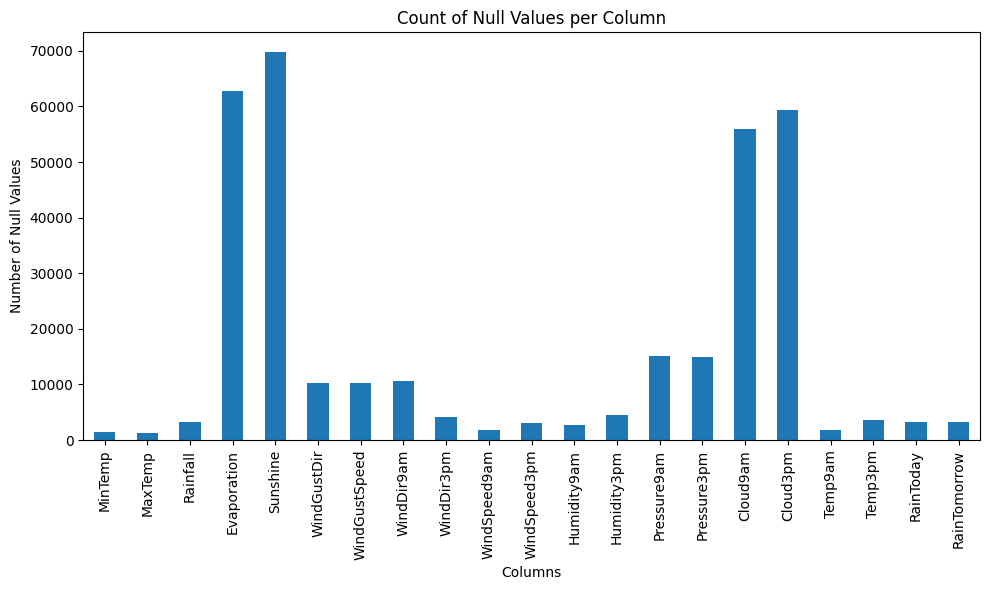

In [232]:
df.dropna(subset=['Date'], inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")


null_counts = df.isnull().sum()

# Filter out columns with zero null values
filtered_null_counts = null_counts[null_counts > 0]

plt.figure(figsize=(10, 6))
filtered_null_counts.plot(kind='bar')
plt.title('Count of Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Seems like there are too many nulls in Evaporation, Sunshine, Cloud9am and Cloud3pm.
All the above may be valuable for prediction. Lets check if they are normally distributed.

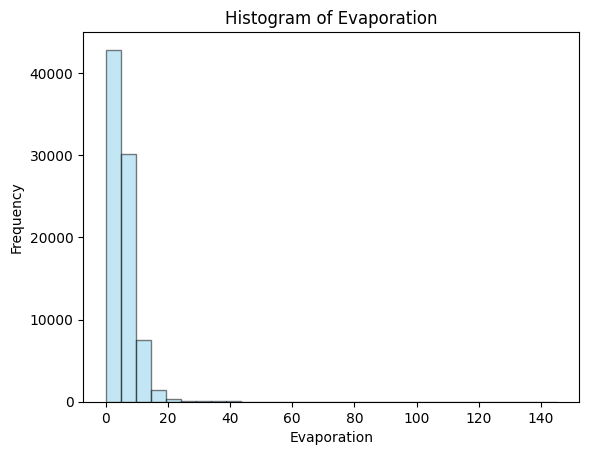

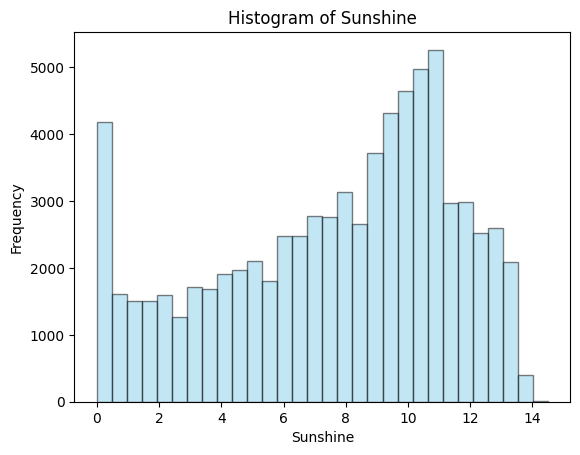

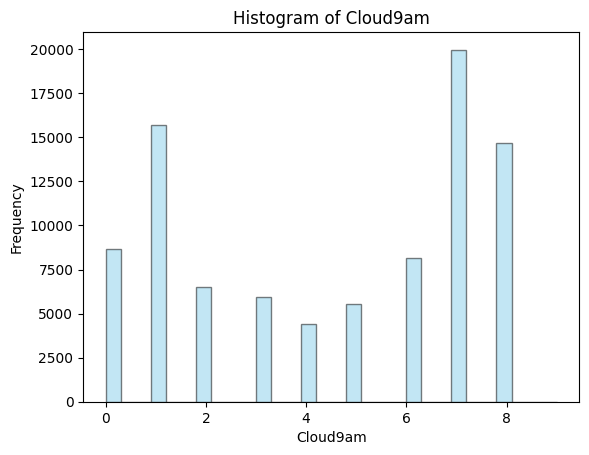

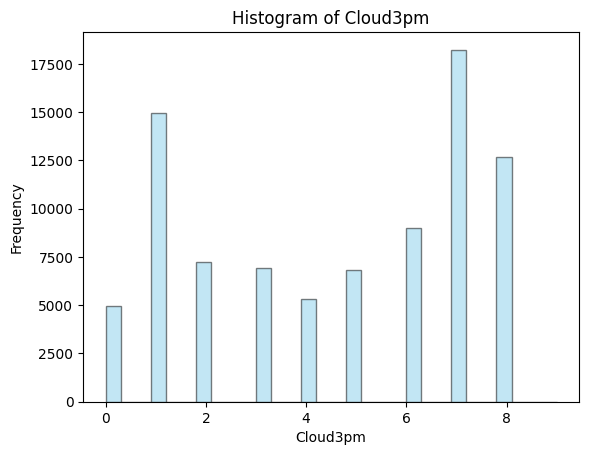

In [233]:
columns_to_check = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']

for column in columns_to_check:
    plt.hist(df[column].dropna(), bins=30, alpha=0.5, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

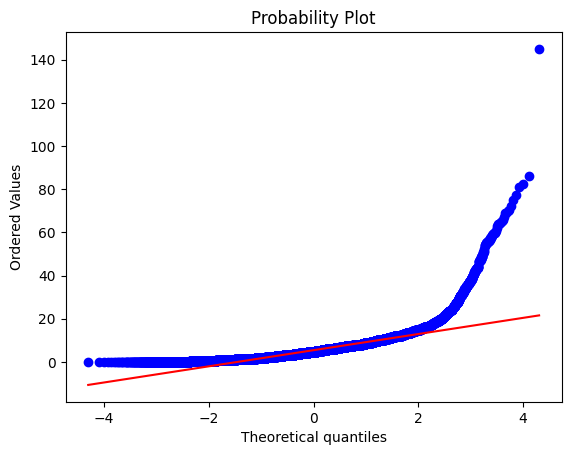

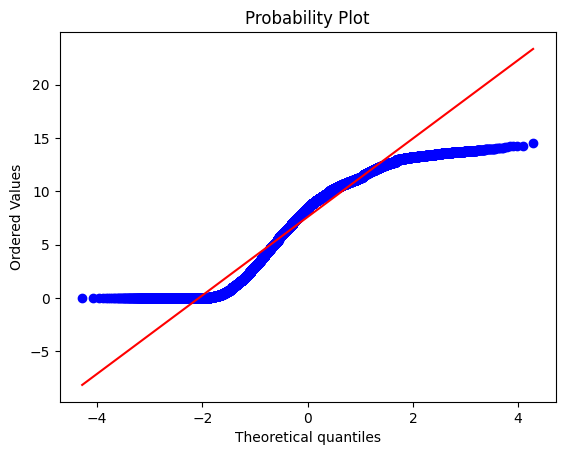

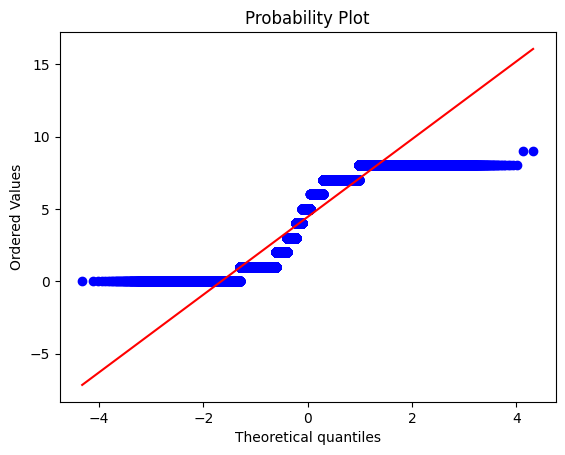

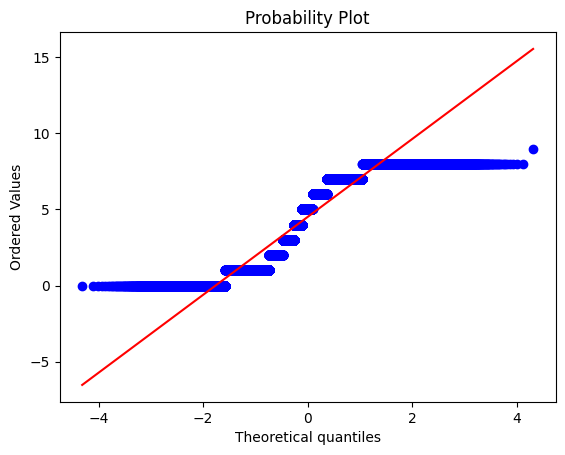

In [234]:
import scipy.stats as stats

def qq_plot(data):
    stats.probplot(data, dist="norm", plot=plt)
    plt.show()

for column in columns_to_check:
    qq_plot(df[column].dropna())


In [235]:
print(df.columns)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


Seems like none of the columns Evaporation, Sunshine, Cloud9am, or Cloud3pm are normally distributed. Therefore, replacing with mean/median is not recommended.
Now to check how they are distributed in time.

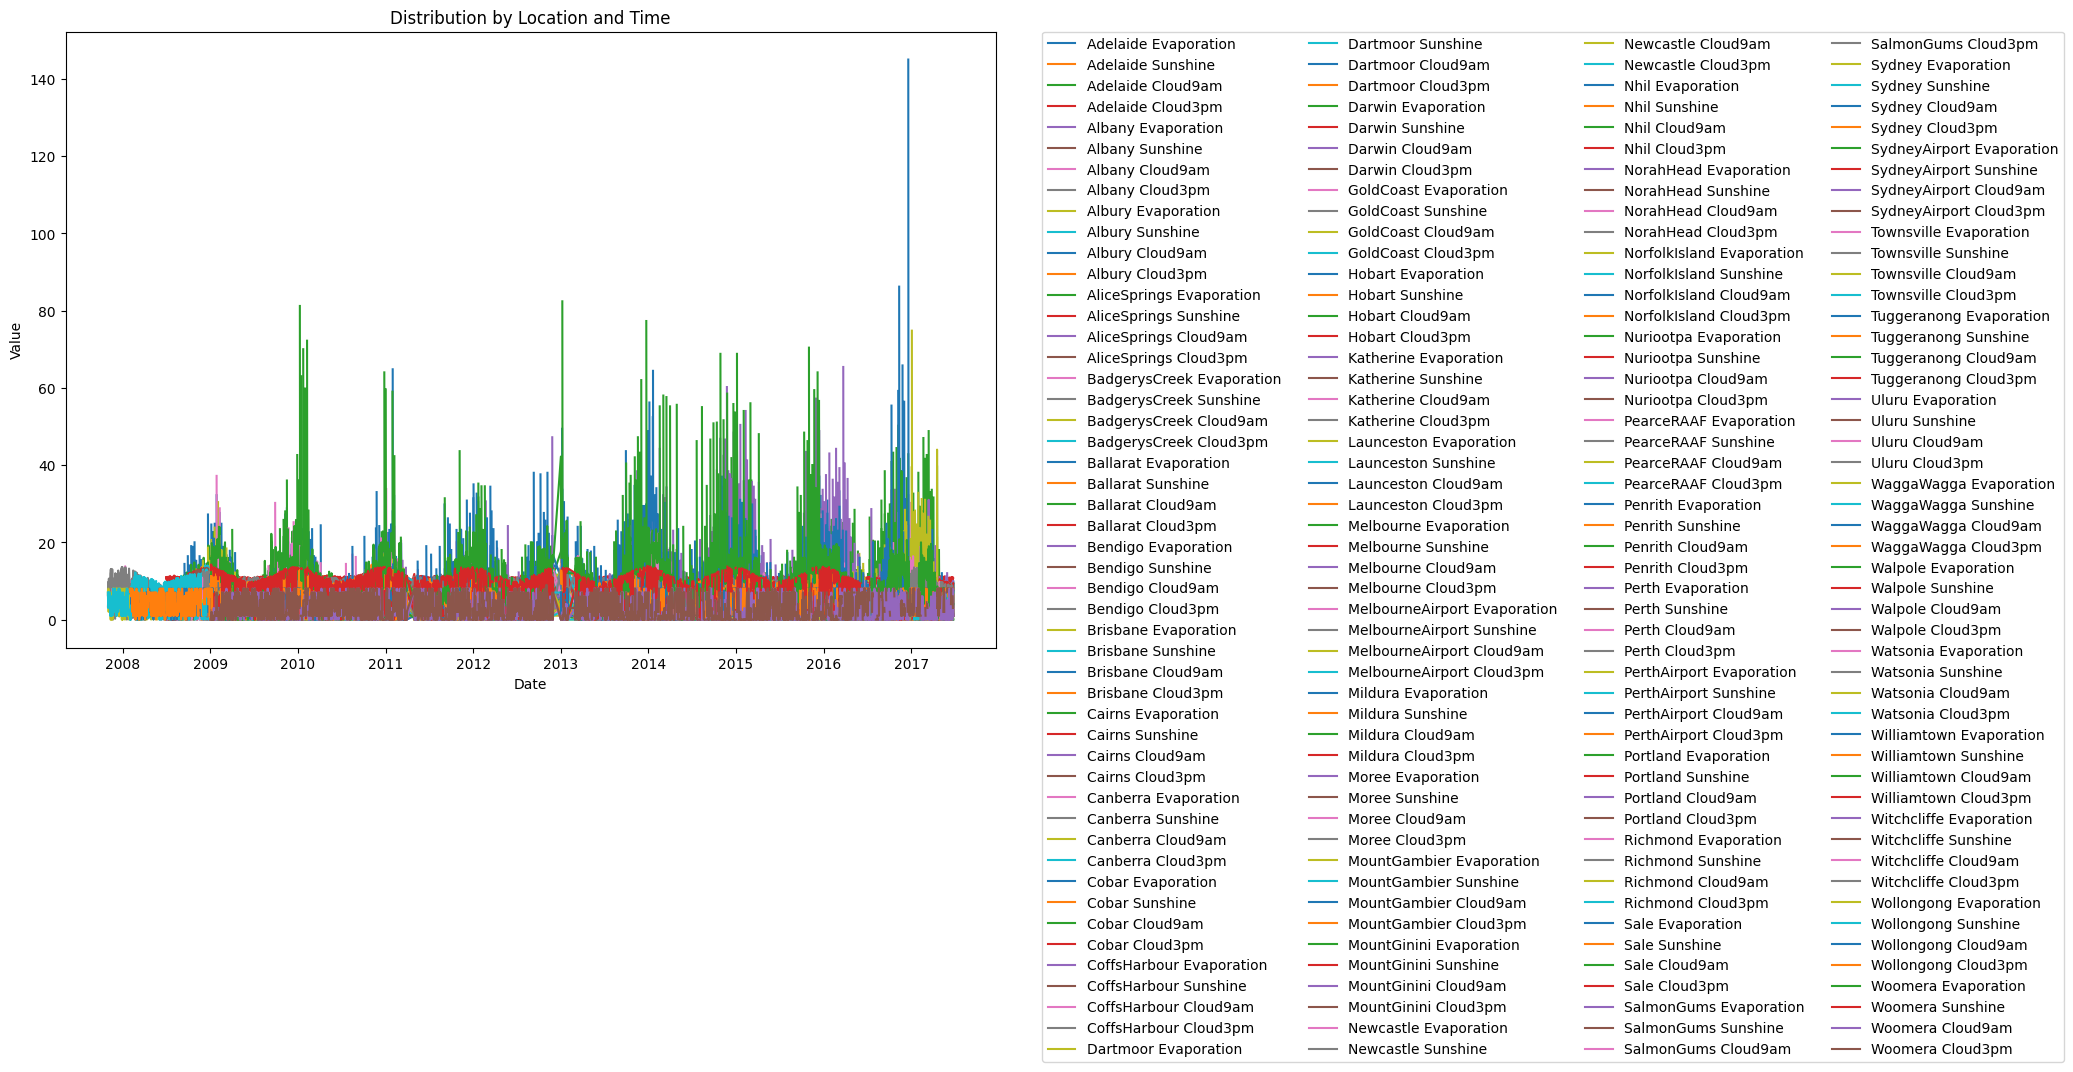

In [236]:
# Convert 'Date' column to datetime if it's not already
groupedDf = df.copy()
groupedDf['Date'] = pd.to_datetime(groupedDf['Date'], format='%d/%m/%Y')
groupedDf.set_index('Date', inplace=True)

numeric_columns = groupedDf.select_dtypes(include=[np.number]).columns
grouped = groupedDf.groupby(['Location', 'Date'])[numeric_columns].mean().reset_index()

locations = grouped['Location'].unique()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each location
for location in locations:
    # Filter data for the current location
    location_data = grouped[grouped['Location'] == location]
    
    # Plot each variable for the current location
    ax.plot(location_data['Date'], location_data['Evaporation'], label=f'{location} Evaporation')
    ax.plot(location_data['Date'], location_data['Sunshine'], label=f'{location} Sunshine')
    ax.plot(location_data['Date'], location_data['Cloud9am'], label=f'{location} Cloud9am')
    ax.plot(location_data['Date'], location_data['Cloud3pm'], label=f'{location} Cloud3pm')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Distribution by Location and Time')
ax.legend(ncol=4, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show the plot
plt.show()




Seems like the data until end of 2008 is pretty choppy so we drop the data before this date.
Also seems like for Evaporation and Sunshine, the data is pretty seasonal, so we can replace nulls using interpolation.

In [237]:
df = df[df['Date'] >= '2009-01-01']
df.set_index('Date', inplace=True)

df.loc[:, ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']] = df[['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']].interpolate(method='linear', limit_direction='forward')

Lets check nulls again

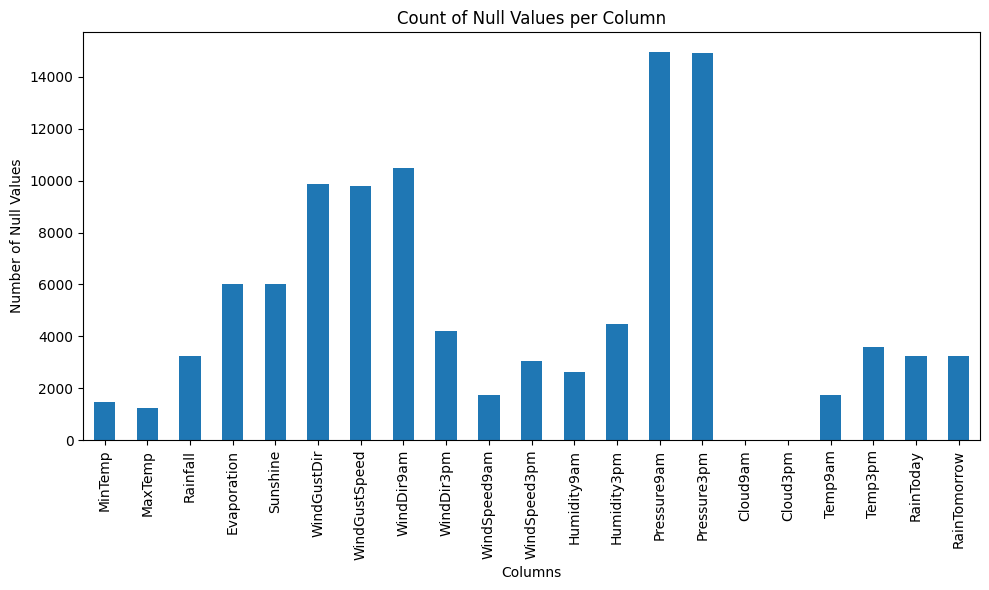

In [238]:
null_counts = df.isnull().sum()

# Filter out columns with zero null values
filtered_null_counts = null_counts[null_counts > 0]

plt.figure(figsize=(10, 6))
filtered_null_counts.plot(kind='bar')
plt.title('Count of Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Drop any N/A values in RainToday or RainTomorrow as they are categorical, very relavant to what we are trying to predict and that total number of missing is small in comparison to the dataset.

For missing values in Windgust directions, we will use the mode as that seems logical and shouldn't affect our final

In [239]:
# Check for missing values
print(df.isnull().sum())

df = df.dropna(subset=['RainToday', 'RainTomorrow'])

# Impute missing values. For numerical we will use means to replace and for categorical we will use mode.
for column in df.columns:
    if df[column].dtype == "float64":
        df[column] = df[column].fillna(df[column].mean())
    elif df[column].dtype == "object":
        df[column] = df[column].fillna(df[column].mode()[0])

df.describe()

Location             0
MinTemp           1474
MaxTemp           1253
Rainfall          3236
Evaporation       6018
Sunshine          6018
WindGustDir       9873
WindGustSpeed     9811
WindDir9am       10474
WindDir3pm        4205
WindSpeed9am      1737
WindSpeed3pm      3043
Humidity9am       2629
Humidity3pm       4484
Pressure9am      14970
Pressure3pm      14934
Cloud9am            21
Cloud3pm            21
Temp9am           1748
Temp3pm           3593
RainToday         3236
RainTomorrow      3243
dtype: int64


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000,138497.000000
mean,12.179701,23.239061,2.350291,6.606513,8.007953,39.946910,13.991569,18.618582,68.881396,51.488142,1017.685113,1015.289607,4.692105,4.735492,16.986831,21.697242
std,6.391302,7.115313,8.486115,5.629377,3.239280,13.146266,8.860031,8.725339,18.997292,20.577700,6.727496,6.664179,2.797818,2.562174,6.479772,6.879503
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,3.200000,6.122664,31.000000,7.000000,13.000000,57.000000,37.000000,1013.600000,1011.100000,2.000000,2.197289,12.300000,16.700000
50%,12.000000,22.700000,0.000000,5.584164,8.300000,39.000000,13.000000,18.618582,70.000000,51.488142,1017.685113,1015.289607,5.373832,5.095206,16.800000,21.300000
75%,16.800000,28.200000,0.800000,8.515254,10.655059,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,7.000000,7.000000,21.500000,26.300000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


Let's check nulls again. We should have no more nulls.

In [240]:
null_counts = print(df.isnull().sum())


Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


So there are no more Nulls. Now lets deal with extreme values.

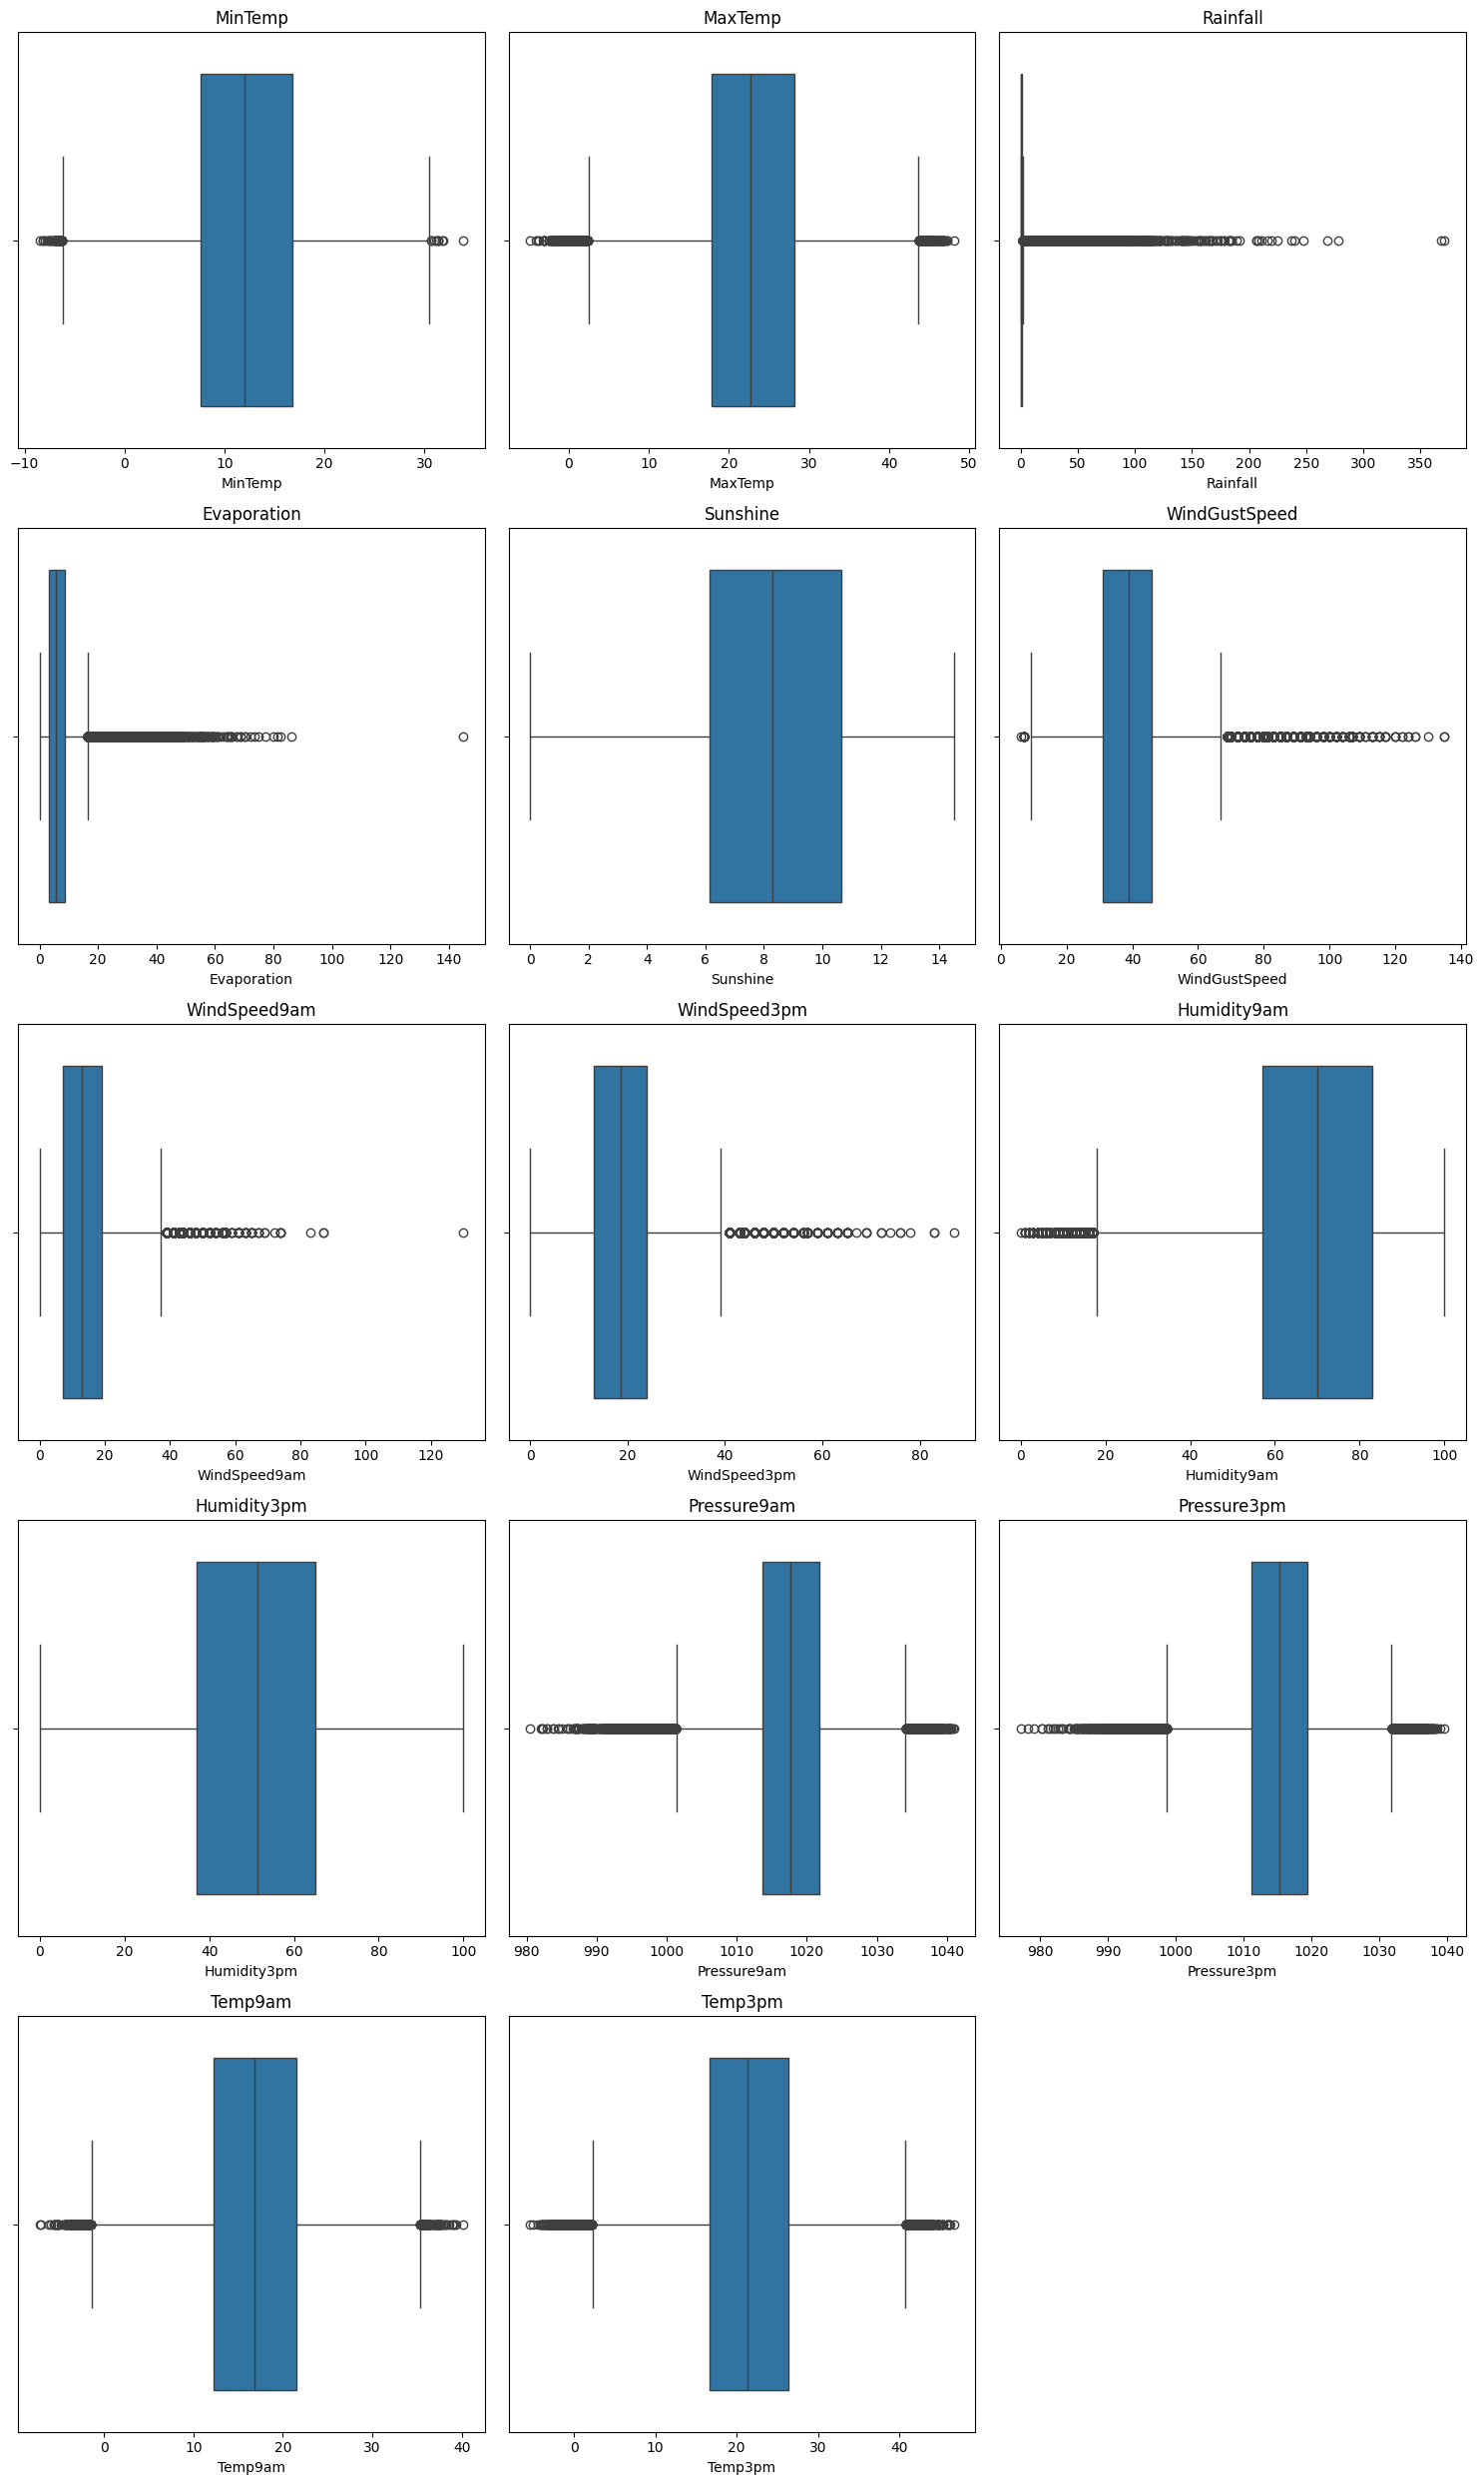

In [241]:
quantitative_variables = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

def plot_boxplots(df, variables, ncols=3):
    """
    Function to plot box plots for a list of variables in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - variables: list of column names to plot
    - ncols: number of columns in the grid of plots
    """
    nrows = len(variables) // ncols + (len(variables) % ncols > 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    
    for i, var in enumerate(variables):
        row = i // ncols
        col = i % ncols
        sns.boxplot(x=df[var], ax=axes[row, col])
        axes[row, col].set_title(var)
    
    # Remove empty subplots
    for j in range(len(variables), nrows*ncols):
        row = j // ncols
        col = j % ncols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

plot_boxplots(df, quantitative_variables)

Looking at the box plots-
- for Temperatures, -mintemp. Range seems to be -10 to ~35 degrees. Maxtemp between -10 and 50 degress. Both ranges are possible in Australia so these can't be ruled as outliers
- For Rainfall, value is in mm. The is same rainfall above 350mm. Again this seems reasonable
- For evaporation, there is only one value which above 100. Assuming this to be an error, let's replace this value with the mean value.
- windgust and wind speeds all seem to be fine be fine with no outliers
- Humidity is between 0 and 100, again seems fine.
- Pressures also seem fine.

There we just need to replace one value for evaporation, wehre there is one value which above 100. Assuming this to be an error, let's replace this value with the mean value.

In [242]:
# Replace all values in 'Evaporation' above 100 with the mean
df['Evaporation'] = np.where(df['Evaporation'] > 100, df['Evaporation'].mean(), df['Evaporation'])

Let's do a correlation matrix.
For RainToday and RainTomorrow, we can just replace Yes with 1 and No with 0. 
The remaining qualitative variables can be one-hot encoded later.

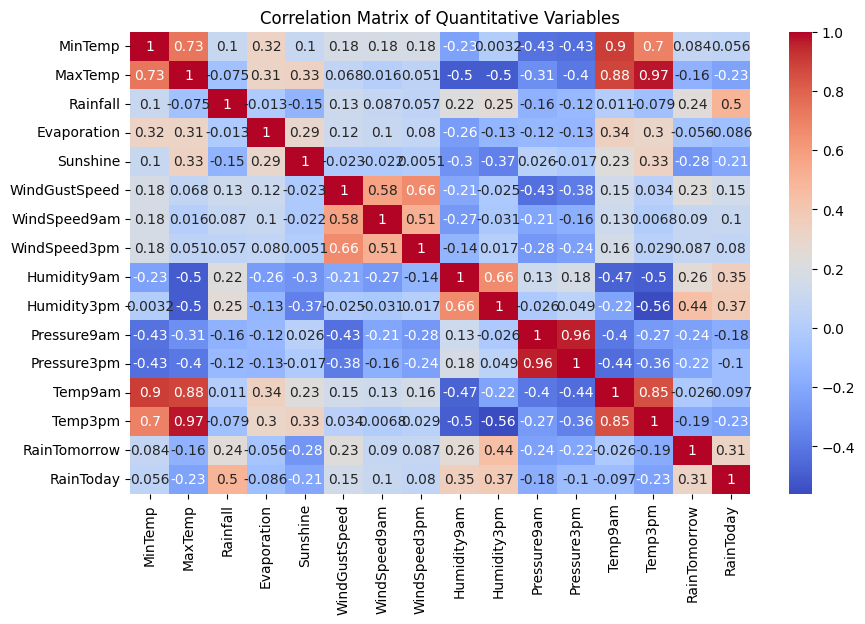

In [243]:
quantitative_variables = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow','RainToday']
df_corr = df.copy()
df_corr['RainTomorrow'] = df_corr['RainTomorrow'].map({'Yes': 1, 'No': 0})
df_corr['RainToday'] = df_corr['RainToday'].map({'Yes': 1, 'No': 0})
df_quantitative = df_corr[quantitative_variables]

correlation_matrix = df_quantitative.corr()['RainTomorrow'].sort_values(ascending=False)

#print(correlation_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(df_quantitative.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Quantitative Variables')
plt.show()

Now lets on-hot encode the categorical variables.
First lets check the unique value distribution in all of them.

In [244]:
# Overview of unique values of categorical columns
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

# Count unique values for each categorical column
for col in categorical_cols:
  n_unique = df[col].nunique()
  print(f"Column '{col}': {n_unique} unique values")

Column 'Location': 49 unique values
Column 'WindGustDir': 16 unique values
Column 'WindDir9am': 16 unique values
Column 'WindDir3pm': 16 unique values
Column 'RainToday': 2 unique values
Column 'RainTomorrow': 2 unique values


In [245]:
# Overview of unique values of categorical columns
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

# Count unique values for each categorical column
for col in categorical_cols:
  n_unique = df[col].nunique()
  print(f"Column '{col}': {n_unique} unique values")

Column 'Location': 49 unique values
Column 'WindGustDir': 16 unique values
Column 'WindDir9am': 16 unique values
Column 'WindDir3pm': 16 unique values
Column 'RainToday': 2 unique values
Column 'RainTomorrow': 2 unique values


In [246]:
# Convert categorical variables to numerical
categorical_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm','RainToday', 'RainTomorrow']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=int)

Now we will scale all the variable for ease of model training.

In [247]:
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,11.3,26.5,0.0,6.606513,8.007953,56.0,19.0,31.0,46.0,26.0,...,0,0,0,0,0,0,1,0,0,0
2009-01-02,9.6,23.9,0.0,6.606513,8.007953,41.0,19.0,11.0,44.0,22.0,...,0,0,0,1,0,0,0,0,0,0
2009-01-03,10.5,28.8,0.0,6.606513,8.007953,26.0,11.0,7.0,43.0,22.0,...,0,0,0,0,0,0,0,0,0,0
2009-01-04,12.3,34.6,0.0,6.606513,8.007953,37.0,6.0,17.0,41.0,12.0,...,0,0,0,0,0,0,0,0,0,0
2009-01-05,12.9,35.8,0.0,6.606513,8.007953,41.0,6.0,26.0,41.0,9.0,...,0,0,0,0,0,0,0,0,0,0


In [248]:
# Define features and target
data = df.drop(['RainTomorrow_Yes'], axis=1)
y = df['RainTomorrow_Yes']

#standardizign the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Create a new dataframe with the scaled data, keeping the same column names
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# combining features and targets
scaled_df = pd.concat([scaled_data, y], axis=1)

scaled_df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,-0.137641,0.458300,-0.276958,0.000178,5.483822e-16,1.221118,0.565286,1.419024,-1.204460,-1.238634,...,-0.269285,-0.33659,-0.262514,-0.245206,-0.263079,-0.273456,3.944201,-0.264894,-0.536173,0
2009-01-02,-0.403628,0.092890,-0.276958,0.000178,5.483822e-16,0.080106,0.565286,-0.873159,-1.309739,-1.433020,...,-0.269285,-0.33659,-0.262514,4.078198,-0.263079,-0.273456,-0.253537,-0.264894,-0.536173,0
2009-01-03,-0.262811,0.781548,-0.276958,0.000178,5.483822e-16,-1.060907,-0.337649,-1.331596,-1.362378,-1.433020,...,-0.269285,-0.33659,-0.262514,-0.245206,-0.263079,-0.273456,-0.253537,-0.264894,-0.536173,0
2009-01-04,0.018822,1.596694,-0.276958,0.000178,5.483822e-16,-0.224164,-0.901983,-0.185504,-1.467656,-1.918984,...,-0.269285,-0.33659,-0.262514,-0.245206,-0.263079,-0.273456,-0.253537,-0.264894,-0.536173,0
2009-01-05,0.112700,1.765345,-0.276958,0.000178,5.483822e-16,0.080106,-0.901983,0.845978,-1.467656,-2.064774,...,-0.269285,-0.33659,-0.262514,-0.245206,-0.263079,-0.273456,-0.253537,-0.264894,-0.536173,0


In [249]:
features = df.drop(columns=['RainTomorrow_Yes'])
target = df['RainTomorrow_Yes']

In [250]:
target.head()

Date
2009-01-01    0
2009-01-02    0
2009-01-03    0
2009-01-04    0
2009-01-05    0
Name: RainTomorrow_Yes, dtype: int32

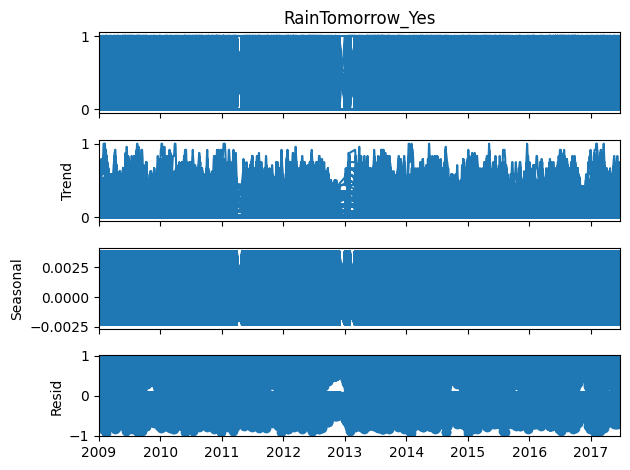

In [251]:
# Seasonal decomposition of the target variable
result = seasonal_decompose(target, model='additive', period=12)

# Plot the decomposition
result.plot()
plt.show()


In [252]:
# Perform Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(target)

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
#for key, value in adf_test[4].items():
#    print('Critical Values:')
#    print(f'   {key}, {value}')

if adf_test[1] <= 0.05:
    print("The series is stationary")
else:
    print("The series is not stationary")

ADF Statistic: -28.422713270952457
p-value: 0.0
The series is stationary


In [253]:
# Split the data into training and test sets (80% training, 20% test)
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.2, random_state=42)

In [254]:
# Define the SARIMAX model
order = (1, 0, 0)  # (p, d, q)
seasonal_order = (0, 1, 1, 12)  # (P, D, Q, s)

In [255]:
# Fit the SARIMAX model on the training data
model = sm.tsa.statespace.SARIMAX(train_target, 
                                  exog=train_features, 
                                  order=order, 
                                  seasonal_order=seasonal_order)

c:\python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [256]:
sarimax_result = model.fit()

c:\python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [257]:
# Save the model to a pickle file
with open('sarimax_model_FINAL.pkl', 'wb') as f:
    pickle.dump(sarimax_result, f)

Note that you need to save the PKL file in models folder for the streamlit to work

In [258]:
sarimax_summary = sarimax_result.summary()

In [259]:
print(sarimax_summary)

                                      SARIMAX Results                                       
Dep. Variable:                     RainTomorrow_Yes   No. Observations:               110797
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood              -39026.159
Date:                              Sun, 29 Sep 2024   AIC                          78278.318
Time:                                      00:39:02   BIC                          79364.853
Sample:                                           0   HQIC                         78606.544
                                           - 110797                                         
Covariance Type:                                opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
MinTemp                      -0.0008      0.001     -1.435      0.15

In [260]:
train_predictions = sarimax_result.predict(start=0, end=len(train_target)-1, exog=train_features)

In [261]:
train_predictions.describe()

count    110797.000000
mean          0.220754
std           0.264527
min          -9.150228
25%           0.046848
50%           0.183710
75%           0.359556
max           2.016546
Name: predicted_mean, dtype: float64

In [262]:
# Make predictions on the test data
test_predictions = sarimax_result.predict(start=len(train_target), 
                                          end=len(train_target) + len(test_target) - 1, 
                                          exog=test_features)

c:\python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [263]:
# Convert predictions to binary classifications
test_predictions_binary = np.where(test_predictions > 0.5, 1, 0)

In [264]:
accuracy = accuracy_score(test_target, test_predictions_binary)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8409386281588448


In [265]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate accuracy metrics
mse = mean_squared_error(test_target, test_predictions)
mae = mean_absolute_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)

# Print the accuracy metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 0.12004402069596644
Mean Absolute Error (MAE): 0.2611742717364763
R^2 Score: 0.30257548565447245


In [266]:
# Print the classification report
print('\nClassification Report:')
print(classification_report(test_target, test_predictions_binary))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90     21580
           1       0.74      0.43      0.55      6120

    accuracy                           0.84     27700
   macro avg       0.80      0.69      0.72     27700
weighted avg       0.83      0.84      0.82     27700

